In [1]:
# This is a basic program which predicts the stock prices of Apple with machine learning 
# Made based on https://www.youtube.com/watch?v=QIUxPv5PJOY

In [2]:
# Libraries

import math
import pandas_datareader as web
from pandas_datareader import data as webdata
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yfin


import datetime

plt.style.use('fivethirtyeight')

2024-07-01 20:39:03.950722: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 20:39:03.954503: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 20:39:03.966537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 20:39:03.989134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 20:39:03.989182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 20:39:04.003635: I tensorflow/core/platform/cpu_feature_guard.cc:

In [3]:
# Get the stock info

yfin.pdr_override()

df = webdata.get_data_yahoo('AAPL', start='2012-01-01', end='2019-12-17')

#df = pd.read_csv('AAPL.csv')

# Show dataframe

df

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.416984,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.483714,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.622308,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.754259,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.734030,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,65.218658,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,65.774948,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,65.942558,137310400


In [4]:
# Get the data num of rows and columns

df.shape

(2002, 6)

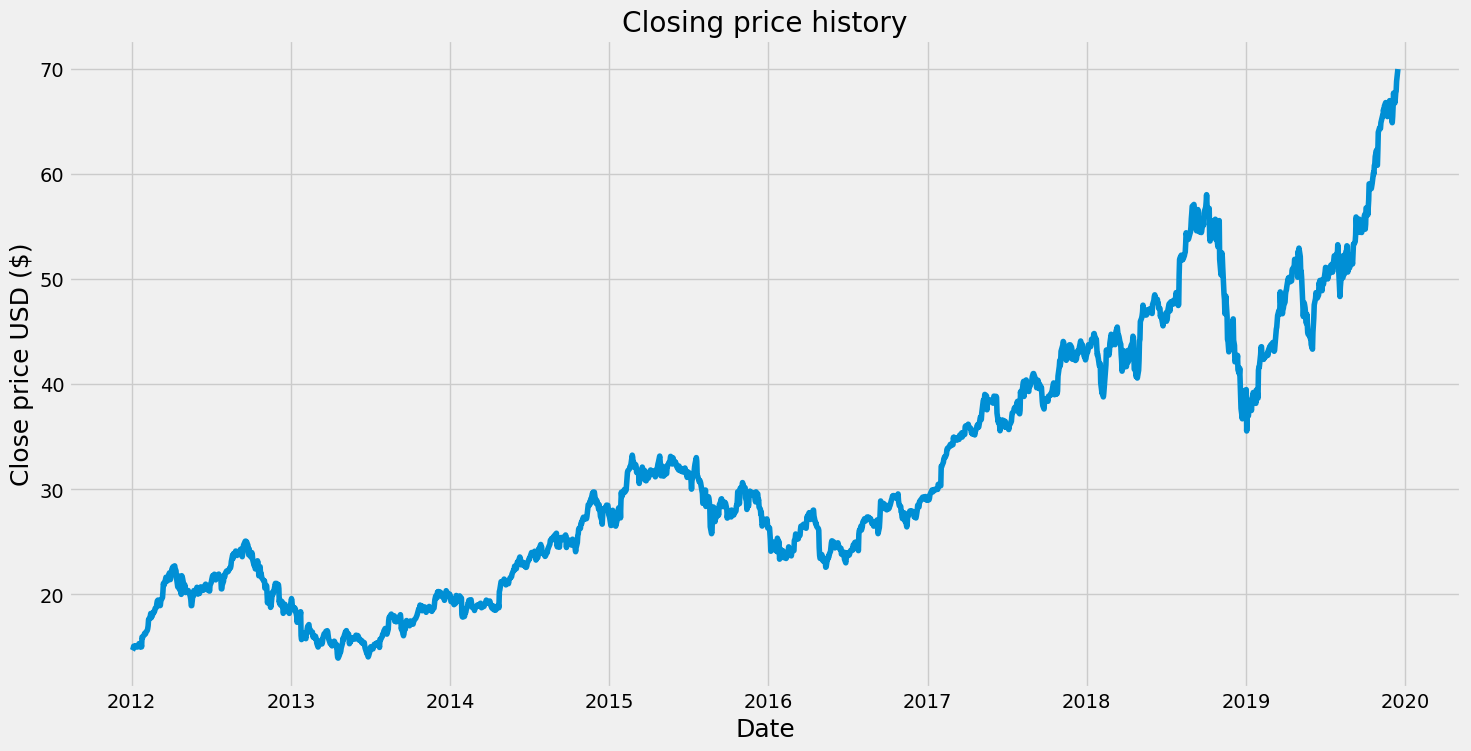

In [5]:
# Visualize the closing price history

plt.figure(figsize = (16, 8))
plt.title("Closing price history")
plt.plot(df['Close'])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close price USD ($)", fontsize = 18)
plt.show()

In [6]:
# Create a new DataFrame with only the 'Close' column

data = df.filter(['Close'])

# Convert the DataFrame to a numpy array

dataset = data.values

# Get the rows to train the model

training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1602

In [7]:
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0131974 ],
       [0.01460639],
       [0.01753278],
       ...,
       [0.96251174],
       [0.97897982],
       [1.        ]])

In [8]:
# Creating the training data for the model

train_data = scaled_data[0:training_data_len, :]

# Split the train data into x_train and y_train

x_train = []
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [9]:
# Conver y and x train arrays to numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Reshape the data
x_train = np.reshape(x_train,( x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1542, 60, 1)

In [11]:
# Build the LSTM model

model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

model.add(LSTM(50, return_sequences = False))

model.add(Dense(25))

model.add(Dense(1))

/home/rafa/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Compile the model

model.compile(optimizer="adam", loss = "mean_squared_error")

In [13]:
# Train the model

model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 0.0013
Epoch 2/3
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - loss: 2.6738e-04
Epoch 3/3
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - loss: 2.3045e-04


In [14]:
# Create test data set

# Create a new array containing scaled values from index 1542 to 2002

test_data = scaled_data[training_data_len -60 : , :]

x_test = []

y_test = dataset[training_data_len :, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])

In [15]:
# Convert the data to a numpy array

x_test = np.array(x_test)

In [16]:
# Reshape the data

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# Get the models to predict the stock prices

predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [18]:
# Evaluate the model with RMSE

rmse = np.sqrt( np.mean( predictions - y_test ) ** 2 )

rmse

0.28814029693603516

/tmp/ipykernel_550819/3157627955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


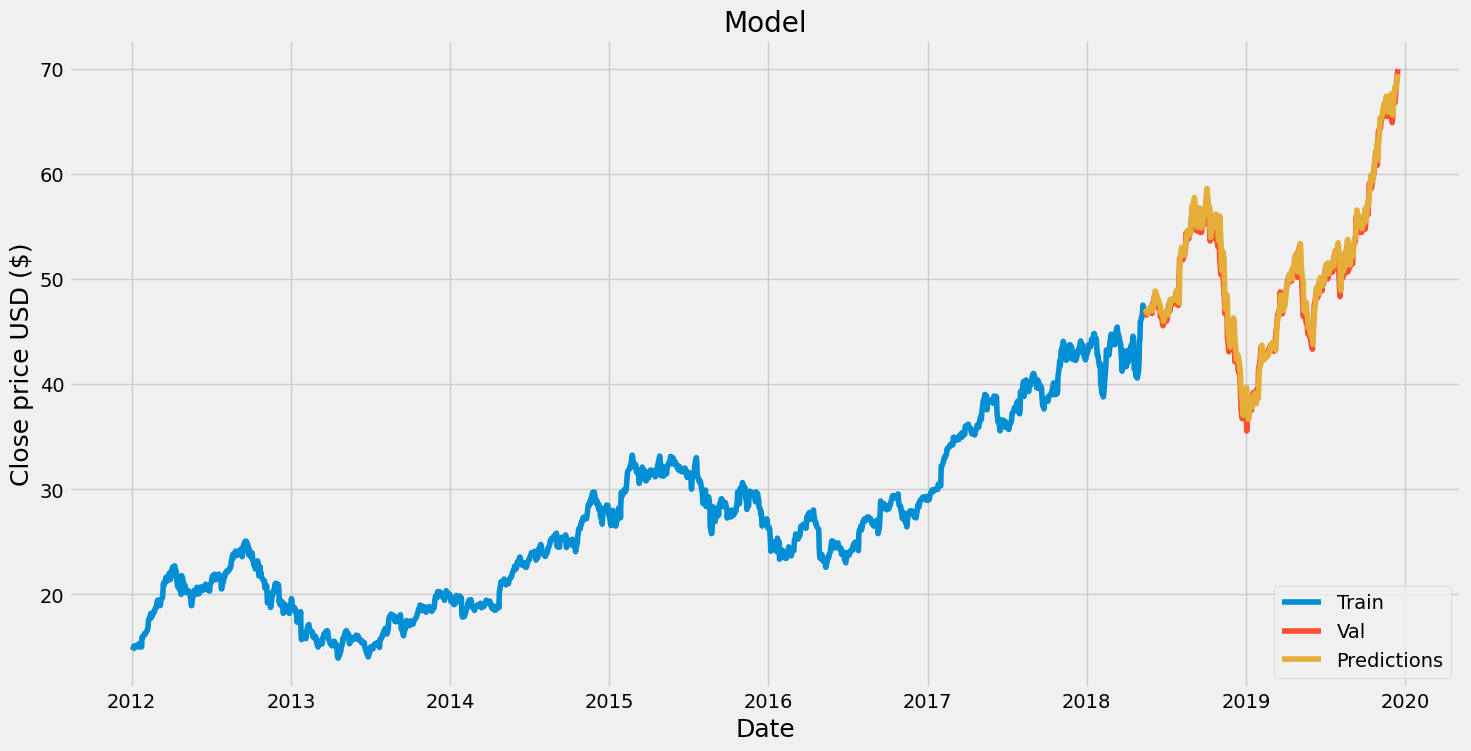

In [19]:
# Plot the data

train = data[:training_data_len]

valid = data[training_data_len:]

valid['Predictions'] = predictions

# Visualize the data

plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close price USD ($)", fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = "lower right")
plt.show()

In [20]:
# Show the actual and predicted stock prices

valid

,Close,Predictions
Date,,
2018-05-16,47.044998,46.840290
2018-05-17,46.747501,46.967556
2018-05-18,46.577499,46.884426
2018-05-21,46.907501,46.723423
2018-05-22,46.790001,46.903831
...,...,...
2019-12-10,67.120003,67.912521
2019-12-11,67.692497,67.899940
2019-12-12,67.864998,68.360764


In [21]:
# Predict the closing price stock on a day outside the dataframe

apple_quote = webdata.get_data_yahoo('AAPL', start = '2012-01-01', end = '2019-12-17')

# Create a new DataFrame

df = apple_quote.filter(['Close'])

# Get the last 60 days closing values and convert the data to an array

last_60_days = df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)

# Empty list

X_test = []

# Append

X_test.append(last_60_days_scaled)

# Convert the data to a numpy array

X_test = np.array(X_test)

# Reshape data

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted stock price

pred_price = model.predict(X_test)

# Undo scaling 

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[70.72383]]


In [22]:
# Check if the predicted price is accurate

apple_quote2 = webdata.get_data_yahoo('AAPL', start = '2019-12-18', end = '2019-12-19')
print(apple_quote2['Close'].values)

[*********************100%%**********************]  1 of 1 completed

[69.93499756]
